In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
def read_data(adr, y_name):
    df = pd.read_csv(adr)
    x = df.loc[:, df.columns != y_name]
    y = df.loc[:, df.columns == y_name]
    return x, y

x, y = read_data('heart.csv', 'target')
x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [11]:
y.head()

,target
0,1
1,1
2,1
3,1
4,1


In [46]:
np.random.seed(173644)
# 173649
# 173648
# 173644 works well for the pruning part!

def shuffle(x, y):
    idx = np.random.permutation(x.index)
    x = x.reindex(idx)
    y = y.reindex(idx)
    return x, y

def data_split(x, y, frac):
    idx = np.random.permutation(x.index)
    train_idx = idx[:int(len(idx) * frac)]
    test_idx = idx[int(len(idx) * frac):len(idx)]
    
    train_x = x.iloc[train_idx, :]
    train_y = y.iloc[train_idx, :]
    test_x = x.iloc[test_idx, :]
    test_y = y.iloc[test_idx, :]
   
    return train_x, train_y, test_x, test_y

x, y = shuffle(x, y)
train_x, train_y, test_x, test_y = data_split(x, y, 0.8)    


In [5]:
y.head()

,target
62,1
58,1
149,1
195,0
292,0


In [7]:
def accuracy(y, y_pred):
    diff = (y == y_pred).to_numpy()
    return np.count_nonzero(diff) / len(y)

In [8]:
from tabulate import tabulate

def confusion_matrix(y, y_pred):
    tp = np.count_nonzero((y_pred == True) & (y == True).to_numpy())
    fp = np.count_nonzero((y_pred == True) & (y == False).to_numpy())
    tn = np.count_nonzero((y_pred == False) & (y == False).to_numpy())
    fn = np.count_nonzero((y_pred == False) & (y == True).to_numpy()) 
    return tp, fp, tn, fn


In [9]:
def classification_report(y, y_pred):
    tp, fp, tn, fn = confusion_matrix(y, y_pred)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    f1_score = 2 * recall * precision / (recall + precision)
    return accuracy, recall, precision, specificity, f1_score  

In [83]:
from scipy.stats import t

def paired_t_test(y1, y2, alpha):
    n = len(y1)
    dif = y1 - y2
    mean = np.mean(dif)
    std = np.std(dif)
    t_stat = mean / (std / np.sqrt(n))
    dof = n - 1
    p_value = (1.0 - t.cdf(abs(t_stat), dof)) * 2.0   
    print("t-stat = ", t_stat[0])
    print("p-value = ", p_value[0])
    print("aplha = ", alpha)
    if p_value > alpha:
        print("Accept the null hypothesis that the predictions are mostly equal.")
    else:
        print("Reject the null hypothesis that the predictions are mostly equal. There is a meaningful difference between estimators.")
    return

In [15]:
class KNN:
  def __init__(self, k):
    self.k = k
    
  def predict(self, test_x):
    test_x = self.scale_features(test_x)
    test_pred = pd.DataFrame(columns = ['target'], index = test_x.index)
    
    for i in range(0, len(test_x)):
        neighbor_indexes = self.find_neighbors(self.x, self.y, test_x.iloc[i], self.k) 
        majority = self.y.iloc[neighbor_indexes].mode()
        test_pred.at[test_x.index[i], 'target'] = majority.at[0, 'target']

    return test_pred

  def euclidean_distance(self, v1, v2):
    dif = v1 - v2
    return np.sqrt(np.sum(dif ** 2))

  def scale_features(self, x):
    x_min, x_max = x.min(), x.max()
    return (x - x_min) / (x_max - x_min)

  def find_neighbors(self, x, y, test_row, k):
    dist = np.zeros(len(x))
    for i in range(0, len(x)):
        dist[i] = self.euclidean_distance(x.iloc[i], test_row)
    indexes = dist.argsort()[0:k]
    return indexes 

  def fit(self, x, y):
    self.x = self.scale_features(x)
    self.y = y
    

In [88]:
from scipy import stats

class Node:
    def __init__(self, pred):
        self.left_child = None
        self.right_child = None
        self.feature = None
        self.pred = pred
        self.bound = 0
        self.pos = 0
        self.neg = 0

class DecisionTree:
  def __init__(self, max_depth, threshold):
    self.max_depth = max_depth
    self.threshold = threshold
    
  def fit(self, x, y):
    self.tree = self.build_tree(x, y, 0) 
    
  def impurity(self, a, b):
    return 1.0 - (a / (a + b)) ** 2 - (b / (a + b)) ** 2
    
  def split(self, x, y):
    best_feature = None
    bound = None
    
    split_count = [y.target.value_counts()[0], y.target.value_counts()[1]]
    best_impurity = self.impurity(split_count[0], split_count[1])
    
    for feature in range(0, x.shape[1]):
        left_split_count = [0, 0]
        right_split_count = split_count.copy()
        x_numpy = x.copy().iloc[:, feature].to_numpy()
        y_numpy = y.copy().iloc[:, 0].to_numpy()  
        x_sorted, y_sorted = zip(*sorted(zip(x_numpy, y_numpy)))
        
        for i in range(1, x.shape[0]):
            target = y_sorted[i - 1]
            left_split_count[target] += 1
            right_split_count[target] -= 1
            
            if x_sorted[i] == x_sorted[i - 1]:
                continue
                
            impurity_left = self.impurity(left_split_count[0], left_split_count[1])
            impurity_right = self.impurity(right_split_count[0], right_split_count[1])
            impurity_total = (i * impurity_left + (x.shape[0] - i) * impurity_right) / x.shape[0]
                
            if impurity_total < best_impurity:
                best_impurity = impurity_total
                best_feature = feature
                bound = (x_sorted[i] + x_sorted[i - 1]) / 2  
    
    return bound, best_feature

  def build_tree(self, x, y, depth):
    node = Node(pred = y.mode().at[0, 'target'])
    node.pos = y.target.sum()
    node.neg = y.size - node.pos
    
    if y.target.value_counts().size == 1:
        return node
                
    if depth < self.max_depth and y.target.value_counts()[0] < self.threshold * y.shape[0]:
        bound, feature = self.split(x, y)
        if feature is not None:
            node.feature = feature
            node.bound = bound
            division = x.iloc[:, feature] < bound
            left_x = x[division]
            right_x = x[~division]
            left_y = y[division]
            right_y = y[~division]           
            node.left_child = self.build_tree(left_x, left_y, depth + 1)
            node.right_child = self.build_tree(right_x, right_y, depth + 1)           

    return node
    
  def predict(self, test_x):
    test_pred = pd.DataFrame(columns = ['target'], index = test_x.index)
    
    for i in range(0, len(test_x)):
        node = self.tree
        while node.left_child:
            if test_x.iloc[i, node.feature] < node.bound:
                node = node.left_child
            else:
                node = node.right_child
        test_pred.at[test_x.index[i], 'target'] = node.pred
    
    return test_pred

def pruning(node):
    left = node.left_child
    right = node.right_child
    
    if left.left_child:
        left = pruning(left)
    if right.left_child:
        right = pruning(right)    
        
    # both children were leaves    
    if not left.left_child and not right.left_child:
        observed = np.array([left.pos, left.neg, right.pos, right.neg])
        s = node.pos + node.neg
        sl = left.pos + left.neg
        sr = right.pos + right.neg
        expected = np.array([sl * node.pos / s, sl * node.neg / s, sr * node.pos / s, sr * node.neg / s])
        if chi_square_prune(0.05, 1, expected, observed):
            node.left_child = None
            node.right_child = None
    return node

def chi_square_prune(alpha, dof, expected, observed):
    z = sum(((expected - observed) ** 2) / expected)
    cv = stats.chi2.ppf(q=1-alpha, df=dof)
    if z > cv:
        return False
    return True

In [93]:
e1 = DecisionTree(13, 0.8)
e1.fit(train_x, train_y)
y1 = e1.predict(test_x)

# Chi_Square pruning of the tree
pruning(e1.tree)
y2 = e1.predict(test_x)

print("** Initial tree accuracy = ", accuracy(y1, test_y))
print("** Pruned tree accuracy = ", accuracy(y2, test_y))
print("\n** T-test Results: ")
paired_t_test(y1, y2, 0.05)

** Initial tree accuracy =  0.819672131147541
** Pruned tree accuracy =  0.8360655737704918

** T-test Results: 
t-stat =  -0.44794854027761066
p-value =  0.6558036402056819
aplha =  0.05
Accept the null hypothesis that the predictions are mostly equal.


In [55]:
def cross_validation(k, x, y, estimator):
    acc = np.zeros(k)
    for i in range(0, k):
        dev_set_x = x.iloc[(int)(i * len(x) / k):(int)((i + 1) * len(x) / k), :]
        dev_set_y = y.iloc[(int)(i * len(y) / k):(int)((i + 1) * len(y) / k), :]
        train_set_x = x[~x.index.isin(dev_set_x.index.tolist())]
        train_set_y = y[~y.index.isin(dev_set_y.index.tolist())]
        
        estimator.fit(train_set_x, train_set_y)
        dev_pred = estimator.predict(dev_set_x)
        acc[i] = accuracy(dev_pred, dev_set_y)
    
    return np.mean(acc)
    
def best_estimator(param_max, est_type):
    best_acc = 0.0
    best_param = 1
    best_est = None

    for i in range(1, param_max + 1):
        e1 = None
        if est_type == "knn":
            e1 = KNN(i)
        elif est_type == "decision tree":    
            e1 = DecisionTree(i, 0.8)
        acc = cross_validation(5, train_x, train_y, e1) 
        if acc > best_acc:
            best_param = i
            best_acc = acc
            best_est = e1

    print('best param: ', best_param)
    print('best accuracy: ', best_acc)
    return best_est    

In [56]:
best_knn = best_estimator(15, "knn")

best param:  4
best accuracy:  0.8264455782312925


In [57]:
best_dt = best_estimator(13, "decision tree")

best param:  3
best accuracy:  0.7765306122448979


In [58]:
# Confusion Matirx and Classification Report for best Decision Tree Classifier

dt_pred = best_dt.predict(test_x)
tp, fp, tn, fn = confusion_matrix(test_y, dt_pred)
print(tabulate([['Predicted Positive', tp, fp], ['Predicted Negative', fn, tn]], headers=['', 'Actually Positive', 'Actually Negative']))
accuracy_score, recall, precision, specificity, f1_score = classification_report(test_y, dt_pred)
print("\n\n")
print(tabulate([[accuracy_score, recall, precision, specificity, f1_score]], headers=['Accuracy', 'Recall', 'Precision', 'Specificity', 'F1 Score']))

                      Actually Positive    Actually Negative
------------------  -------------------  -------------------
Predicted Positive                   33                   11
Predicted Negative                    1                   16



  Accuracy    Recall    Precision    Specificity    F1 Score
----------  --------  -----------  -------------  ----------
  0.803279  0.970588         0.75       0.592593    0.846154


In [59]:
# Confusion Matirx and Classification Report for best KNN Classifier

knn_pred = best_knn.predict(test_x)
tp, fp, tn, fn = confusion_matrix(test_y, knn_pred)
print(tabulate([['Predicted Positive', tp, fp], ['Predicted Negative', fn, tn]], headers=['', 'Actually Positive', 'Actually Negative']))
accuracy_score, recall, precision, specificity, f1_score = classification_report(test_y, knn_pred)
print("\n\n")
print(tabulate([[accuracy_score, recall, precision, specificity, f1_score]], headers=['Accuracy', 'Recall', 'Precision', 'Specificity', 'F1 Score']))

                      Actually Positive    Actually Negative
------------------  -------------------  -------------------
Predicted Positive                   30                    8
Predicted Negative                    4                   19



  Accuracy    Recall    Precision    Specificity    F1 Score
----------  --------  -----------  -------------  ----------
  0.803279  0.882353     0.789474       0.703704    0.833333


In [84]:
paired_t_test(dt_pred, knn_pred, 0.05)

t-stat =  2.5796405669289375
p-value =  0.012357695872700747
aplha =  0.05
Reject the null hypothesis that the predictions are mostly equal. There is a meaningful difference between estimators.


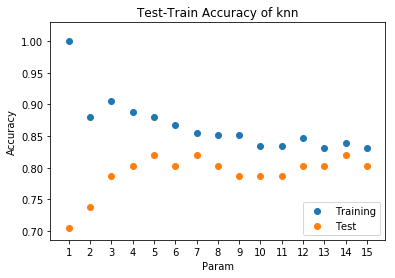

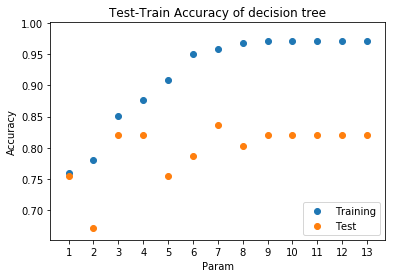

In [49]:
def accuracy_plot(param_max, est_type):
    train_acc = np.zeros(param_max)
    test_acc = np.zeros(param_max)
    
    for i in range(1, param_max + 1): 
        e1 = None
        if est_type == "knn":
            e1 = KNN(i)
        elif est_type == "decision tree":    
            e1 = DecisionTree(i, 0.8)
        e1.fit(train_x, train_y)
        
        test_pred = e1.predict(test_x)
        test_acc[i-1] = accuracy(test_pred, test_y)
        
        train_pred = e1.predict(train_x)
        train_acc[i-1] = accuracy(train_pred, train_y)
    
    plt.scatter(range(1, param_max + 1), train_acc, label='Training')
    plt.scatter(range(1, param_max + 1), test_acc, label='Test')
    plt.xticks(np.arange(1, param_max + 1, 1.0))

    plt.xlabel("Param")
    plt.ylabel("Accuracy")
    
    plt.legend(loc='lower right')
    plt.title("Test-Train Accuracy of " + est_type)
    plt.show()
        
accuracy_plot(15, "knn")
accuracy_plot(13, "decision tree")        